In [122]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
#The applications module provides access to various pre-trained deep learning models like VGG16, ResNet, Inception, etc., which are trained on large datasets (e.g., ImageNet).
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

In [124]:
# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0  # Normalize
y_train_full, y_test_full = to_categorical(y_train_full), to_categorical(y_test_full)

In [4]:
x_train_full.shape,x_test_full.shape,y_train_full.shape,y_test_full.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [6]:
x_train_full[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

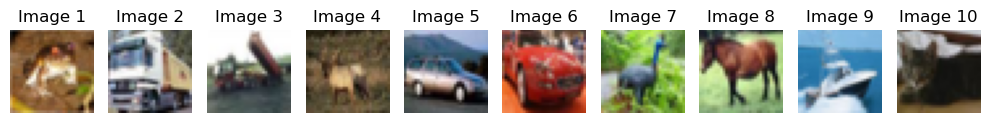

In [18]:
#To visualize the first 15 images from your X_train dataset with a shape of (50000, 32, 32, 3)
import matplotlib.pyplot as plt

# Display the first 5 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train_full[i])
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.tight_layout()
plt.show()

We'll use:

- 1000 samples for training.
- 400 samples for validation.
- 400 samples for testing.

In [20]:
# Randomly select subsets for training, validation, and testing
np.random.seed(42)
train_indices = np.random.choice(len(x_train_full), 1000, replace=False)
val_indices = np.random.choice(list(set(range(len(x_train_full))) - set(train_indices)), 400, replace=False)
test_indices = np.random.choice(len(x_test_full), 400, replace=False)

x_train = x_train_full[train_indices]
y_train = y_train_full[train_indices]
x_val = x_train_full[val_indices]
y_val = y_train_full[val_indices]
x_test = x_test_full[test_indices]
y_test = y_test_full[test_indices]

In [22]:
x_train.shape,x_val.shape,x_test.shape

((1000, 32, 32, 3), (400, 32, 32, 3), (400, 32, 32, 3))

In [24]:
y_train.shape, y_val.shape,y_test.shape

((1000, 10), (400, 10), (400, 10))

In [26]:
# Resize images to 224x224 for VGG16
 # CIFAR-10 images are 32x32
x_train_resized = tf.image.resize(x_train, (224, 224))
x_val_resized = tf.image.resize(x_val, (224, 224))
x_test_resized = tf.image.resize(x_test, (224, 224))

In [28]:
x_train_resized.shape,x_val_resized.shape,x_test_resized.shape

(TensorShape([1000, 224, 224, 3]),
 TensorShape([400, 224, 224, 3]),
 TensorShape([400, 224, 224, 3]))

# ===Architecture 1: Integrated End-to-End Model: Transfer Learning with Model Training ===

#  Training on the New Dataset
- Instantiate a pre-trained model (VGG16).
- Freeze its layers.
- Add a custom classifier on top.
- Train the new model.

In [30]:
# Load pre-trained VGG16
base_model_vgg16 = applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet') 
#applications.VGG16:Loads the pre-trained VGG16 model. VGG16 is a convolutional neural network (CNN) with 16 layers, pre-trained on the ImageNet dataset (1,000 classes).
#Parameters:input_shape=(224, 224, 3):Specifies the input size of the images. VGG16 requires inputs of size 224 x 224 pixels with 3 color channels (RGB).
#include_top=False:Removes the fully connected layers (the "top" part) that are typically used for classification.
#This makes the model suitable for feature extraction or transfer learning when customizing the classifier for a new task.
#weights='imagenet':Indicates that the model should load the weights pre-trained on the ImageNet dataset.

base_model_vgg16.trainable = False  # Freezes the layers of the pre-trained VGG16 model so that their weights are not updated during training.
#Freezing is done to retain the learned features from ImageNet and prevent overfitting when fine-tuning the model for a new task.
#Only the newly added layers (e.g., for classification) will be trained.

#Since include_top=False, the output size of the last layer depends on the number of filters in the final convolutional layer of VGG16 (typically (7, 7, 512) for 224x224 input).

base_model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Add a custom head
model_1 = models.Sequential([
    base_model_vgg16,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [34]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
7*7*512

25088

In [36]:
7*7*512*256+256

6422784

In [42]:
256*10+10

2570

In [44]:
6422784+2570

6425354

The parameters can be categorized into trainable and non-trainable based on the model architecture and the settings applied. Here's the breakdown:

### Non-Trainable Parameters
1. **Base Model (VGG16)**:
   - The entire VGG16 model is loaded with `trainable` set to `False`. This means that all the weights and biases of the layers in the VGG16 model are non-trainable. These layers will not be updated during the training process. The layers in VGG16 include:
     - Convolutional layers
     - Pooling layers
     - Batch normalization layers (if any)
   - Since `include_top=False` is specified, the fully connected layers at the top of the VGG16 model are not included, but all other layers remain non-trainable.

### Trainable Parameters
2. **Custom Head**:
   - The layers added after the VGG16 base model are trainable by default. These include:
     - **Flatten Layer**: This layer does not have parameters to train; it simply reshapes the output from the VGG16 model.
     - **Dense Layer (256 units)**: This layer has trainable parameters (weights and biases) that will be updated during training.
     - **Dropout Layer**: This layer does not have trainable parameters; it is used to prevent overfitting by randomly dropping units during training.
     - **Dense Layer (10 units)**: This final layer also has trainable parameters (weights and biases) that will be updated during training.

### Summary
- **Non-Trainable Parameters**: All parameters in the VGG16 base model (convolutional and pooling layers).
- **Trainable Parameters**: Parameters in the custom head, specifically the weights and biases of the two Dense layers (256 units and 10 units). The Flatten and Dropout layers do not have trainable parameters. 

In conclusion, the model consists of a mix of non-trainable parameters from the pre-trained VGG16 model and trainable parameters from the custom layers added on top.

In [56]:



# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_1 = model_1.fit(
    x_train_resized, y_train, 
    validation_data=(x_val_resized, y_val), 
    epochs=3, batch_size=32
)



Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 292s 9s/step - accuracy: 0.2056 - loss: 2.0166 - val_accuracy: 0.3075 - val_loss: 1.9182
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 286s 9s/step - accuracy: 0.2310 - loss: 1.9323 - val_accuracy: 0.3450 - val_loss: 1.8718
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 284s 9s/step - accuracy: 0.2351 - loss: 1.9879 - val_accuracy: 0.3650 - val_loss: 1.7989


In [57]:
# Evaluate the model
loss_1, accuracy_1 = model_1.evaluate(x_test_resized, y_test)
print(f"Workflow 1 - Test Loss: {loss_1}, Test Accuracy: {accuracy_1}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.3601 - loss: 1.7726
Workflow 1 - Test Loss: 1.788771152496338, Test Accuracy: 0.36000001430511475


**Architecture 1:**
- Direct Integration:
The pre-trained VGG16 model is directly part of the complete model (model_1).
- Feature Extraction During Training:
Input images are passed through the frozen VGG16 layers to extract features.
The extracted features are flattened and passed through additional fully connected layers for classification.
- Trainable Layers:
VGG16 is frozen (trainable=False), so only the fully connected layers are trained.
- End-to-End Training:
The entire architecture is built as one model, and predictions are made by passing raw images through the entire model.
- Flexibility:
Easier to integrate and manage as a single model.
- Input Size:
Input images must match the VGG16 input size (224x224x3).


# === Architecture 2: Two-Stage Workflow: Feature Extraction ===

In [60]:
# === Workflow 2: Feature Extraction ===
#Run the new dataset through the frozen base model.
#Extract features and use them as input for a smaller model.

# Extract features using thepretrained VGG16 base model
feature_extractor = models.Model(inputs=base_model_vgg16.input, outputs=base_model_vgg16.output)

In [61]:
feature_extractor.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [62]:
#creates a new model called `feature_extractor` using the Keras `Model` class. It takes the input layer of the pre-trained VGG16 
#model (`base_model_vgg16.input`) and outputs the final layer of the same model (`base_model_vgg16.output`). This allows the model
#to output the features extracted from the images instead of class predictions
features_train = feature_extractor.predict(x_train_resized)#The output, `features_train`, contains the extracted features for each image in the training set.
features_val = feature_extractor.predict(x_val_resized)
features_test = feature_extractor.predict(x_test_resized)


#code snippet is crucial for transforming the original image data into a feature representation that 
#can be used as input for a smaller model designed for classification tasks.

# Create a smaller model for classification
model_2 = models.Sequential([
    layers.Flatten(input_shape=features_train.shape[1:]),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step


C:\Users\ashis\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
features_train.shape

(1000, 7, 7, 512)

32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step

What it Represents:
- This indicates that the feature_extractor.predict(x_train_resized) operation processed 32 batches of data (likely the number of batches in your x_train_resized dataset).
- Each batch took approximately 3 seconds to process, with a total time of 110 seconds.

13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

What it Represents:
- Similarly, this shows that the validation (x_val_resized) and test (x_test_resized) datasets were processed in 13 batches each.
- Each batch also took around 3 seconds, and the total time was 40 seconds for each dataset.

In [63]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,425,354 (24.51 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

This output provides a summary of the parameters in a neural network model, specifically detailing the total number of parameters, trainable parameters, non-trainable parameters, and optimizer parameters. Here’s a breakdown of each component:

1. **Total params: 19,276,064 (73.53 MB)**:
   - This indicates the total number of parameters in the model, which is 19,276,064. Parameters include weights and biases that the model learns during training. The size in memory is also provided, which is approximately 73.53 megabytes (MB).

2. **Trainable params: 6,425,354 (24.51 MB)**:
   - This number represents the parameters that can be updated during training (i.e., those that will be adjusted based on the loss function and backpropagation). In this case, there are 6,425,354 trainable parameters, which occupy about 24.51 MB of memory. These parameters are typically associated with the layers that are not frozen (i.e., layers that are being trained).

3. **Non-trainable params: 0 (0.00 B)**:
   - Non-trainable parameters are those that are not updated during training. This could include parameters from layers that have been frozen (e.g., layers from a pre-trained model that are not being fine-tuned). In this case, there are no non-trainable parameters, indicating that all parameters in the model are trainable.

4. **Optimizer params: 12,850,710 (49.02 MB)**:
   - This refers to the parameters associated with the optimizer used in training the model. Optimizers maintain their own parameters (like momentum terms in Adam or RMSprop) that are used to adjust the weights during training. Here, there are 12,850,710 optimizer parameters, which take up about 49.02 MB of memory.

In [64]:
# Compile the smaller model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the smaller model
history_2 = model_2.fit(
    features_train, y_train,
    validation_data=(features_val, y_val),
    epochs=3, batch_size=32
)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1310 - loss: 3.9146 - val_accuracy: 0.1800 - val_loss: 2.1899
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1919 - loss: 2.1637 - val_accuracy: 0.2175 - val_loss: 2.0416
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1894 - loss: 2.0751 - val_accuracy: 0.2600 - val_loss: 2.0170


In [65]:

# Evaluate the smaller model on the test set
loss_2, accuracy_2 = model_2.evaluate(features_test, y_test)
print(f"Workflow 2 - Test Loss: {loss_2}, Test Accuracy: {accuracy_2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2982 - loss: 2.0155
Workflow 2 - Test Loss: 1.9996986389160156, Test Accuracy: 0.3174999952316284


**Architecture 2**

- Two Stages:
    - Stage 1: Use feature_extractor (VGG16 without the "top" layers) to compute feature maps for the entire dataset (features_train, features_val, features_test).
    - Stage 2: Build and train a separate classifier (model_2) on the precomputed feature maps.
- Precomputing Features:
Feature extraction is done once for the dataset, which speeds up training.
- Trainable Layers:
Only the fully connected layers (model_2) are trained. The VGG16 feature extractor is completely static and not involved in training.
- Training Process:
The feature extractor is run independently, and training is performed only on the classifier (model_2).
- Flexibility:
Allows the use of extracted features with multiple models or classifiers.
- Input Size:
Raw input images must still match the VGG16 input size (224x224x3) during feature extraction. The classifier (model_2) works with the shape of the extracted features.
  

- Architecture 1 (Training): May perform slightly better since it involves fine-tuning during training.
- Architecture 2 (Feature Extraction): Faster, but performance might be slightly lower due to no data augmentation.

# Implementation: Workflow 1 with Data Augmentation

In [69]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
#used for real-time data augmentation, which helps improve the model's performance by artificially expanding the training dataset through various transformations (like rotation, shifting, etc.).
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# imports the `to_categorical` function, which is used to convert class labels (integers) into a one-hot encoded format. This is necessary for multi-class classification problems, as it allows the model to output probabilities for each class.
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [70]:
# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0  # Normalize
y_train_full, y_test_full = to_categorical(y_train_full), to_categorical(y_test_full)

# Randomly select subsets for training, validation, and testing
np.random.seed(42)
train_indices = np.random.choice(len(x_train_full), 1000, replace=False)
val_indices = np.random.choice(list(set(range(len(x_train_full))) - set(train_indices)), 400, replace=False)
test_indices = np.random.choice(len(x_test_full), 400, replace=False)

x_train = x_train_full[train_indices]
y_train = y_train_full[train_indices]
x_val = x_train_full[val_indices]
y_val = y_train_full[val_indices]
x_test = x_test_full[test_indices]
y_test = y_test_full[test_indices]

# Resize images to 224x224 for VGG16
 # CIFAR-10 images are 32x32
x_train_resized = tf.image.resize(x_train, (224, 224))
x_val_resized = tf.image.resize(x_val, (224, 224))
x_test_resized = tf.image.resize(x_test, (224, 224))



In [71]:
x_train.shape,x_val.shape,x_test.shape

((1000, 32, 32, 3), (400, 32, 32, 3), (400, 32, 32, 3))

In [72]:
x_train_resized.shape,x_val_resized.shape,x_test_resized.shape,y_train.shape,y_val.shape,y_test.shape

(TensorShape([1000, 224, 224, 3]),
 TensorShape([400, 224, 224, 3]),
 TensorShape([400, 224, 224, 3]),
 (1000, 10),
 (400, 10),
 (400, 10))

In [74]:
# Load the pre-trained VGG16 model with frozen layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model


In [75]:
# Add custom layers on top of the base model
model_1 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [76]:
type(x_train_resized)

tensorflow.python.framework.ops.EagerTensor

In [77]:
import numpy as np

print(isinstance(x_train_resized, np.ndarray))  # Should return True
print(isinstance(y_train, np.ndarray))         # Should return True

False
True


In [96]:
type(x_train_resized)

tensorflow.python.framework.ops.EagerTensor

In [98]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [100]:
# Fit the data generator to the training data
datagen.fit(x_train_resized)  #OPTIONAL STEP

In [102]:
# Ensure that x_train_resized and y_train are properly defined and not empty
# Check the shapes of the training data
print(f"x_train_resized shape: {x_train_resized.shape}, y_train shape: {y_train.shape}")

x_train_resized shape: (1000, 224, 224, 3), y_train shape: (1000, 10)


In [104]:
#Datagen expects both x_train_resized and y_train as numpy array

import numpy as np

print(isinstance(x_train_resized, np.ndarray))  # Should return True
print(isinstance(y_train, np.ndarray))         # Should return True

False
True


In [106]:
x_train_resized = np.array(x_train_resized)
y_train = np.array(y_train)

In [108]:
import numpy as np

print(isinstance(x_train_resized, np.ndarray))  # Should return True
print(isinstance(y_train, np.ndarray))         # Should return True

True
True


In [110]:
#ImageDataGenerator.flow() requires the input features (x_train_resized) and labels (y_train) to have compatible lengths.
#Verify lengths:

print(f"Length of x_train_resized: {len(x_train_resized)}, Length of y_train: {len(y_train)}")


Length of x_train_resized: 1000, Length of y_train: 1000


In [112]:
#Debugging the Generator
batch = datagen.flow(x_train_resized, y_train, batch_size=32)
x_batch, y_batch = next(batch)
print(x_batch.shape, y_batch.shape)  # Should print something like (32, 224, 224, 3), (32, 10)

(32, 224, 224, 3) (32, 10)


In [115]:
history_1 = model_1.fit(
    datagen.flow(x_train_resized, y_train, batch_size=32),
    validation_data=(x_val_resized, y_val),
    epochs=3
)


C:\Users\ashis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.1034 - loss: 3.6862 - val_accuracy: 0.1425 - val_loss: 2.2955
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.1253 - loss: 2.2976 - val_accuracy: 0.1875 - val_loss: 2.2794
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.1272 - loss: 2.2740 - val_accuracy: 0.1800 - val_loss: 2.2267


In [116]:

# Evaluate the model on the test set
loss_1, accuracy_1 = model_1.evaluate(x_test_resized, y_test)  # Ensure x_test and y_test are defined
print(f"Workflow 1 with Data Augmentation - Test Loss: {loss_1}, Test Accuracy: {accuracy_1}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.1458 - loss: 2.2301
Workflow 1 with Data Augmentation - Test Loss: 2.2270679473876953, Test Accuracy: 0.1525000035762787


**HERE I HAVE USED VERY LESS VOLUME OF DATA AND USED LESS NUMBER OF EPOCHS FOR CHECKING THE FLOW . U CAN TRY WITH THE WHOLE DATASETS AND MORE EPOCHS TO GET GOOD RESULTS**


In [118]:
#ASHIS KUMAR SAHU